In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb

In [ ]:
import wandb
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, logging, EarlyStoppingCallback, pipeline
logging.set_verbosity_error()
from datasets import load_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_name = "castorini/afriberta_small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 labels for negative, neutral, positive

# Set max length since this model uses a SentencePiece tokenizer
tokenizer.model_max_length = 512

In [ ]:
# Define label mapping
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

# Load the TSV datasets
dataset = load_dataset('csv',
                       data_files={
                           'train': '/content/drive/MyDrive/finetuning data/train.tsv',
                           'validation': '/content/drive/MyDrive/finetuning data/dev.tsv',
                           'test': '/content/drive/MyDrive/finetuning data/test.tsv'
                       },
                       delimiter='\t')

# Map string labels to numerical labels
def map_labels(example):
    example['label'] = label_mapping[example['label']]  # Map string label to numerical
    return example

# Map labels in the dataset
dataset = dataset.map(map_labels)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/14172 [00:00<?, ? examples/s]

Map:   0%|          | 0/2677 [00:00<?, ? examples/s]

Map:   0%|          | 0/5303 [00:00<?, ? examples/s]

In [ ]:
print(dataset['train'][0])

{'tweet': '@user Da kudin da Arewa babu wani abin azo agani da yayi wa alummah allah ya isa yacucemu wlh yarikitamana kasa yarikitamana kasuwanci harkar ilimi harkar lfy hanyoyi babu lantarki dasuransu komai yalalace ga cinhanci da rashawa a fili ko ina a Nigeria jamiyaryar su tabataman mlm 😭🗣', 'label': 0}


In [ ]:
# Tokenizing the dataset
def preprocess_function(examples):
    # Assuming your text column is named 'sentence', replace with the actual column name
    return tokenizer(examples['tweet'], padding='max_length', truncation=True)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/14172 [00:00<?, ? examples/s]

Map:   0%|          | 0/2677 [00:00<?, ? examples/s]

Map:   0%|          | 0/5303 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets['train']
eval_dataset = tokenized_datasets['validation']
test_dataset = tokenized_datasets['test']

In [ ]:
print(train_dataset[0])

{'tweet': '@user Da kudin da Arewa babu wani abin azo agani da yayi wa alummah allah ya isa yacucemu wlh yarikitamana kasa yarikitamana kasuwanci harkar ilimi harkar lfy hanyoyi babu lantarki dasuransu komai yalalace ga cinhanci da rashawa a fili ko ina a Nigeria jamiyaryar su tabataman mlm 😭🗣', 'label': 0, 'input_ids': [0, 1430, 352, 8115, 625, 2813, 270, 3387, 1979, 511, 1120, 9728, 1128, 379, 270, 1791, 272, 719, 2615, 714, 21272, 268, 1146, 5330, 1106, 518, 67471, 1379, 19658, 5846, 786, 1379, 19658, 5846, 6989, 7944, 8036, 7944, 261, 15724, 466, 12510, 1979, 10309, 270, 39854, 2423, 6186, 268, 12592, 1106, 340, 1726, 704, 3407, 270, 9343, 273, 10590, 324, 731, 273, 351, 1397, 1276, 1276, 378, 288, 5038, 1101, 395, 14463, 261, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# Define training arguments with a reduced learning rate and logging to Tensorboard
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=1e-5,  # Reduced learning rate
    weight_decay=0.01,
    save_total_limit=2,
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save checkpoints at the end of each epoch
    load_best_model_at_end=True,  # Load the best model at the end
    logging_dir='./logs',
    #logging_steps=500,
    report_to="tensorboard",  # Changed from 'tensorflow' to 'tensorboard'
)

# Define compute_metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Create the Trainer, adding EarlyStoppingCallback for early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement after 3 evaluations
)

In [ ]:
# Train the model
train_results = trainer.train()

{'loss': 0.7963, 'grad_norm': 12.273927688598633, 'learning_rate': 9.43566591422122e-06, 'epoch': 0.28216704288939054}
{'loss': 0.6807, 'grad_norm': 14.81746768951416, 'learning_rate': 8.871331828442438e-06, 'epoch': 0.5643340857787811}
{'loss': 0.6582, 'grad_norm': 18.990991592407227, 'learning_rate': 8.306997742663657e-06, 'epoch': 0.8465011286681715}
{'eval_loss': 0.6027183532714844, 'eval_accuracy': 0.7418752334703026, 'eval_f1': 0.7453182340915097, 'eval_precision': 0.7584137771600152, 'eval_recall': 0.7418752334703026, 'eval_runtime': 24.7457, 'eval_samples_per_second': 108.181, 'eval_steps_per_second': 13.538, 'epoch': 1.0}
{'loss': 0.5835, 'grad_norm': 20.259967803955078, 'learning_rate': 7.742663656884877e-06, 'epoch': 1.1286681715575622}
{'loss': 0.5165, 'grad_norm': 23.4731388092041, 'learning_rate': 7.178329571106095e-06, 'epoch': 1.4108352144469527}
{'loss': 0.5295, 'grad_norm': 19.651840209960938, 'learning_rate': 6.613995485327315e-06, 'epoch': 1.6930022573363432}
{'loss

In [ ]:
print(train_results)

TrainOutput(global_step=7088, training_loss=0.4991353104399774, metrics={'train_runtime': 1844.9934, 'train_samples_per_second': 38.407, 'train_steps_per_second': 4.802, 'train_loss': 0.4991353104399774, 'epoch': 4.0})


In [ ]:
trainer.log_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =        4.0
  train_loss               =     0.4991
  train_runtime            = 0:30:44.99
  train_samples_per_second =     38.407
  train_steps_per_second   =      4.802


In [ ]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()

{'eval_loss': 0.5575165748596191, 'eval_accuracy': 0.7710123272319761, 'eval_f1': 0.7716491329019635, 'eval_precision': 0.7757608747155988, 'eval_recall': 0.7710123272319761, 'eval_runtime': 24.6695, 'eval_samples_per_second': 108.514, 'eval_steps_per_second': 13.58, 'epoch': 4.0}


In [ ]:
test_results = trainer.predict(test_dataset)
print(test_results)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming test_results is the output from trainer.predict(test_dataset)
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)

# Define label names
labels = ["Negative", "Neutral", "Positive"]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with label names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
model.save_pretrained("/content/drive/MyDrive/baseline/finetuned_afriberta_sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/baseline/finetuned_afriberta_sentiment_model")

In [ ]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/baseline/finetuned_afriberta_sentiment_model")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/baseline/finetuned_afriberta_sentiment_model")

# Setup a pipeline for sentiment analysis
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
# Make predictions
text = "duk wanda yayi mana haka allah ya isa"
sentiment = sentiment_analysis(text)
print(sentiment)

[{'label': 'LABEL_0', 'score': 0.945100724697113}]


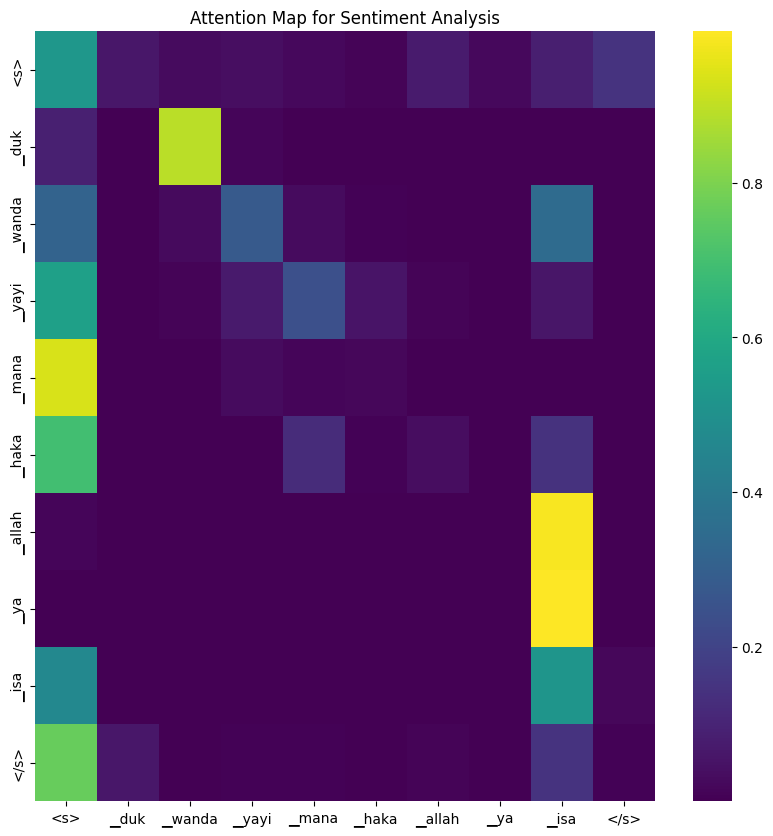

In [ ]:
# Tokenize the text
inputs = tokenizer(text, return_tensors='pt')

# Run the model and get the attention weights
outputs = model(**inputs, output_attentions=True)
attention = outputs.attentions  # This will give you a list of attention scores across layers

# Extract the attention weights for the last layer
attention_last_layer = attention[-3][0]  # Last layer, first batch
attention_map = attention_last_layer[0].detach().cpu().numpy()  # First attention head

# Plot the attention map
plt.figure(figsize=(10, 10))
sns.heatmap(attention_map, xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]),
            yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), cmap='viridis')
plt.title("Attention Map for Sentiment Analysis")
plt.show()